# Unpaired PBMC evaluation

Evaluate how good the imputed PBMC data is

In [1]:
import os
import sys
import importlib

import numpy as np
import pandas as pd
import sklearn
from sklearn import feature_extraction
import anndata as ad
import scanpy as sc
import mvlearn
import matplotlib.pyplot as plt

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'babel')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import sc_data_loaders
import adata_utils
import interpretation
import metrics
import plot_utils
import utils

## Load in predictions and annotations

This `.loom` file corresponds to the PBMC data and analysis described at:
https://satijalab.org/signac/articles/pbmc_vignette.html

In [2]:
pbmc_seurat_atac = ad.read_loom(
    "/home/wukevin/projects/commonspace/data/10x/seurat_pbmc_atac_vignette_atac.loom",
)
pbmc_seurat_atac

/home/wukevin/miniconda3/envs/commonspace/lib/python3.7/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


AnnData object with n_obs × n_vars = 6980 × 78594 
    obs: 'ClusterID', 'ClusterName', 'DNase_sensitive_region_fragments', 'TSS_enrichment', 'TSS_fragments', 'TSS_percentile', 'blacklist_ratio', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'high_tss', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'nCount_RNA', 'nCount_peaks', 'nFeature_RNA', 'nFeature_peaks', 'nucleosome_group', 'nucleosome_percentile', 'nucleosome_signal', 'on_target_fragments', 'orig_ident', 'passed_filters', 'pct_reads_in_peaks', 'peak_region_cutsites', 'peak_region_fragments', 'peaks_snn_res_0_8', 'promoter_region_fragments', 'seurat_clusters', 'total', 'unmapped'
    var: 'Selected', 'count', 'percentile'
    layers: 'norm_data'

In [3]:
pbmc_seurat_atac.obs

,ClusterID,ClusterName,DNase_sensitive_region_fragments,TSS_enrichment,TSS_fragments,TSS_percentile,blacklist_ratio,blacklist_region_fragments,cell_id,chimeric,...,orig_ident,passed_filters,pct_reads_in_peaks,peak_region_cutsites,peak_region_fragments,peaks_snn_res_0_8,promoter_region_fragments,seurat_clusters,total,unmapped
AAACGAAAGAGCGAAA-1,1,CD14 Mono,8529,4.623532,4152,0.20,0.000301,2,_cell_0,235,...,SeuratProject,10444,63.605900,12838,6643,0,4284,0,23649,840
AAACGAAAGAGTTTGA-1,1,CD14 Mono,9539,4.438665,4855,0.13,0.000616,5,_cell_1,191,...,SeuratProject,11111,73.026733,15620,8114,4,5070,4,21864,190
AAACGAAAGCGAGCTA-1,7,NK CD56Dim,17405,5.384285,10689,0.62,0.000926,13,_cell_2,607,...,SeuratProject,21556,65.132675,27405,14040,7,10986,7,46356,330
AAACGAAAGTGCTGAG-1,1,CD14 Mono,6970,5.315153,3781,0.58,0.000000,0,_cell_4,144,...,SeuratProject,8253,69.804916,11175,5761,0,3871,0,16140,132
AAACGAAGTCAGGCTC-1,2,CD4 Memory,3969,4.817101,2637,0.29,0.000946,3,_cell_5,84,...,SeuratProject,5144,61.625195,6211,3170,1,2703,1,10766,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCATGCTTT-1,1,CD14 Mono,7349,5.397088,3778,0.63,0.000347,2,_cell_8628,149,...,SeuratProject,8976,64.226830,11149,5765,0,3851,0,18934,127
TTTGTGTTCCGAGAGA-1,1,CD14 Mono,7528,5.134192,3841,0.48,0.000781,5,_cell_8629,177,...,SeuratProject,8879,72.057663,12372,6398,4,4042,4,17997,97
TTTGTGTTCGAAGCCC-1,12,NK CD56bright,11512,5.332720,7379,0.59,0.001749,17,_cell_8630,401,...,SeuratProject,13665,71.115990,19009,9718,12,7707,12,25915,118
TTTGTGTTCTACTTTG-1,6,CD8 Naive,16461,5.624919,10849,0.74,0.001765,24,_cell_8631,688,...,SeuratProject,20179,67.372017,26642,13595,6,11137,6,45128,302


This loads in the ATAC > RNA predictions generated by BABEL

In [4]:
pbmc_rna = ad.read_h5ad(
    "/home/wukevin/projects/commonspace_eval_7000/eval10xPBMC_cv_logsplit_01/atac_rna_adata.h5ad"
)
if not isinstance(pbmc_rna.X, np.ndarray):
    pbmc_rna.X = pbmc_rna.X.toarray()
pbmc_rna

AnnData object with n_obs × n_vars = 8633 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [5]:
# Subset to the cells that we have Signac annotations for
intersected_barcodes = [bc for bc in pbmc_rna.obs_names if bc in pbmc_seurat_atac.obs_names]
pbmc_rna = pbmc_rna[intersected_barcodes]
pbmc_rna

View of AnnData object with n_obs × n_vars = 6980 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [6]:
pbmc_rna.obs['seurat_clustername'] = pbmc_seurat_atac.obs['ClusterName']
pbmc_rna.obs.head()

Trying to set attribute `.obs` of view, making a copy.


,source_file,n_counts,log1p_counts,n_genes,size_factors,seurat_clustername
index,,,,,,
AAACGAAAGAGCGAAA-1,/home/wukevin/projects/commonspace/data/10x/at...,2194.0,7.693937,2194,1.0,CD14 Mono
AAACGAAAGAGTTTGA-1,/home/wukevin/projects/commonspace/data/10x/at...,2771.0,7.927324,2771,1.0,CD14 Mono
AAACGAAAGCGAGCTA-1,/home/wukevin/projects/commonspace/data/10x/at...,2599.0,7.863267,2599,1.0,NK CD56Dim
AAACGAAAGTGCTGAG-1,/home/wukevin/projects/commonspace/data/10x/at...,1856.0,7.526718,1856,1.0,CD14 Mono
AAACGAAGTCAGGCTC-1,/home/wukevin/projects/commonspace/data/10x/at...,413.0,6.025866,413,1.0,CD4 Memory


In [7]:
# Compute size-normalized, log-normalized counts
pbmc_rna_log = adata_utils.normalize_count_table(pbmc_rna, size_factors=True, log_trans=True, normalize=False)
pbmc_rna_log

INFO:root:Computing size factors
INFO:root:Log transforming data


AnnData object with n_obs × n_vars = 6980 × 34861 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors', 'seurat_clustername'
    uns: 'median_counts'

In [8]:
# Perform dimensionality reduction and clustering
plot_utils.preprocess_anndata(pbmc_rna_log, louvain_resolution=0, leiden_resolution=0.8)

INFO:root:Skipping louvain clustering


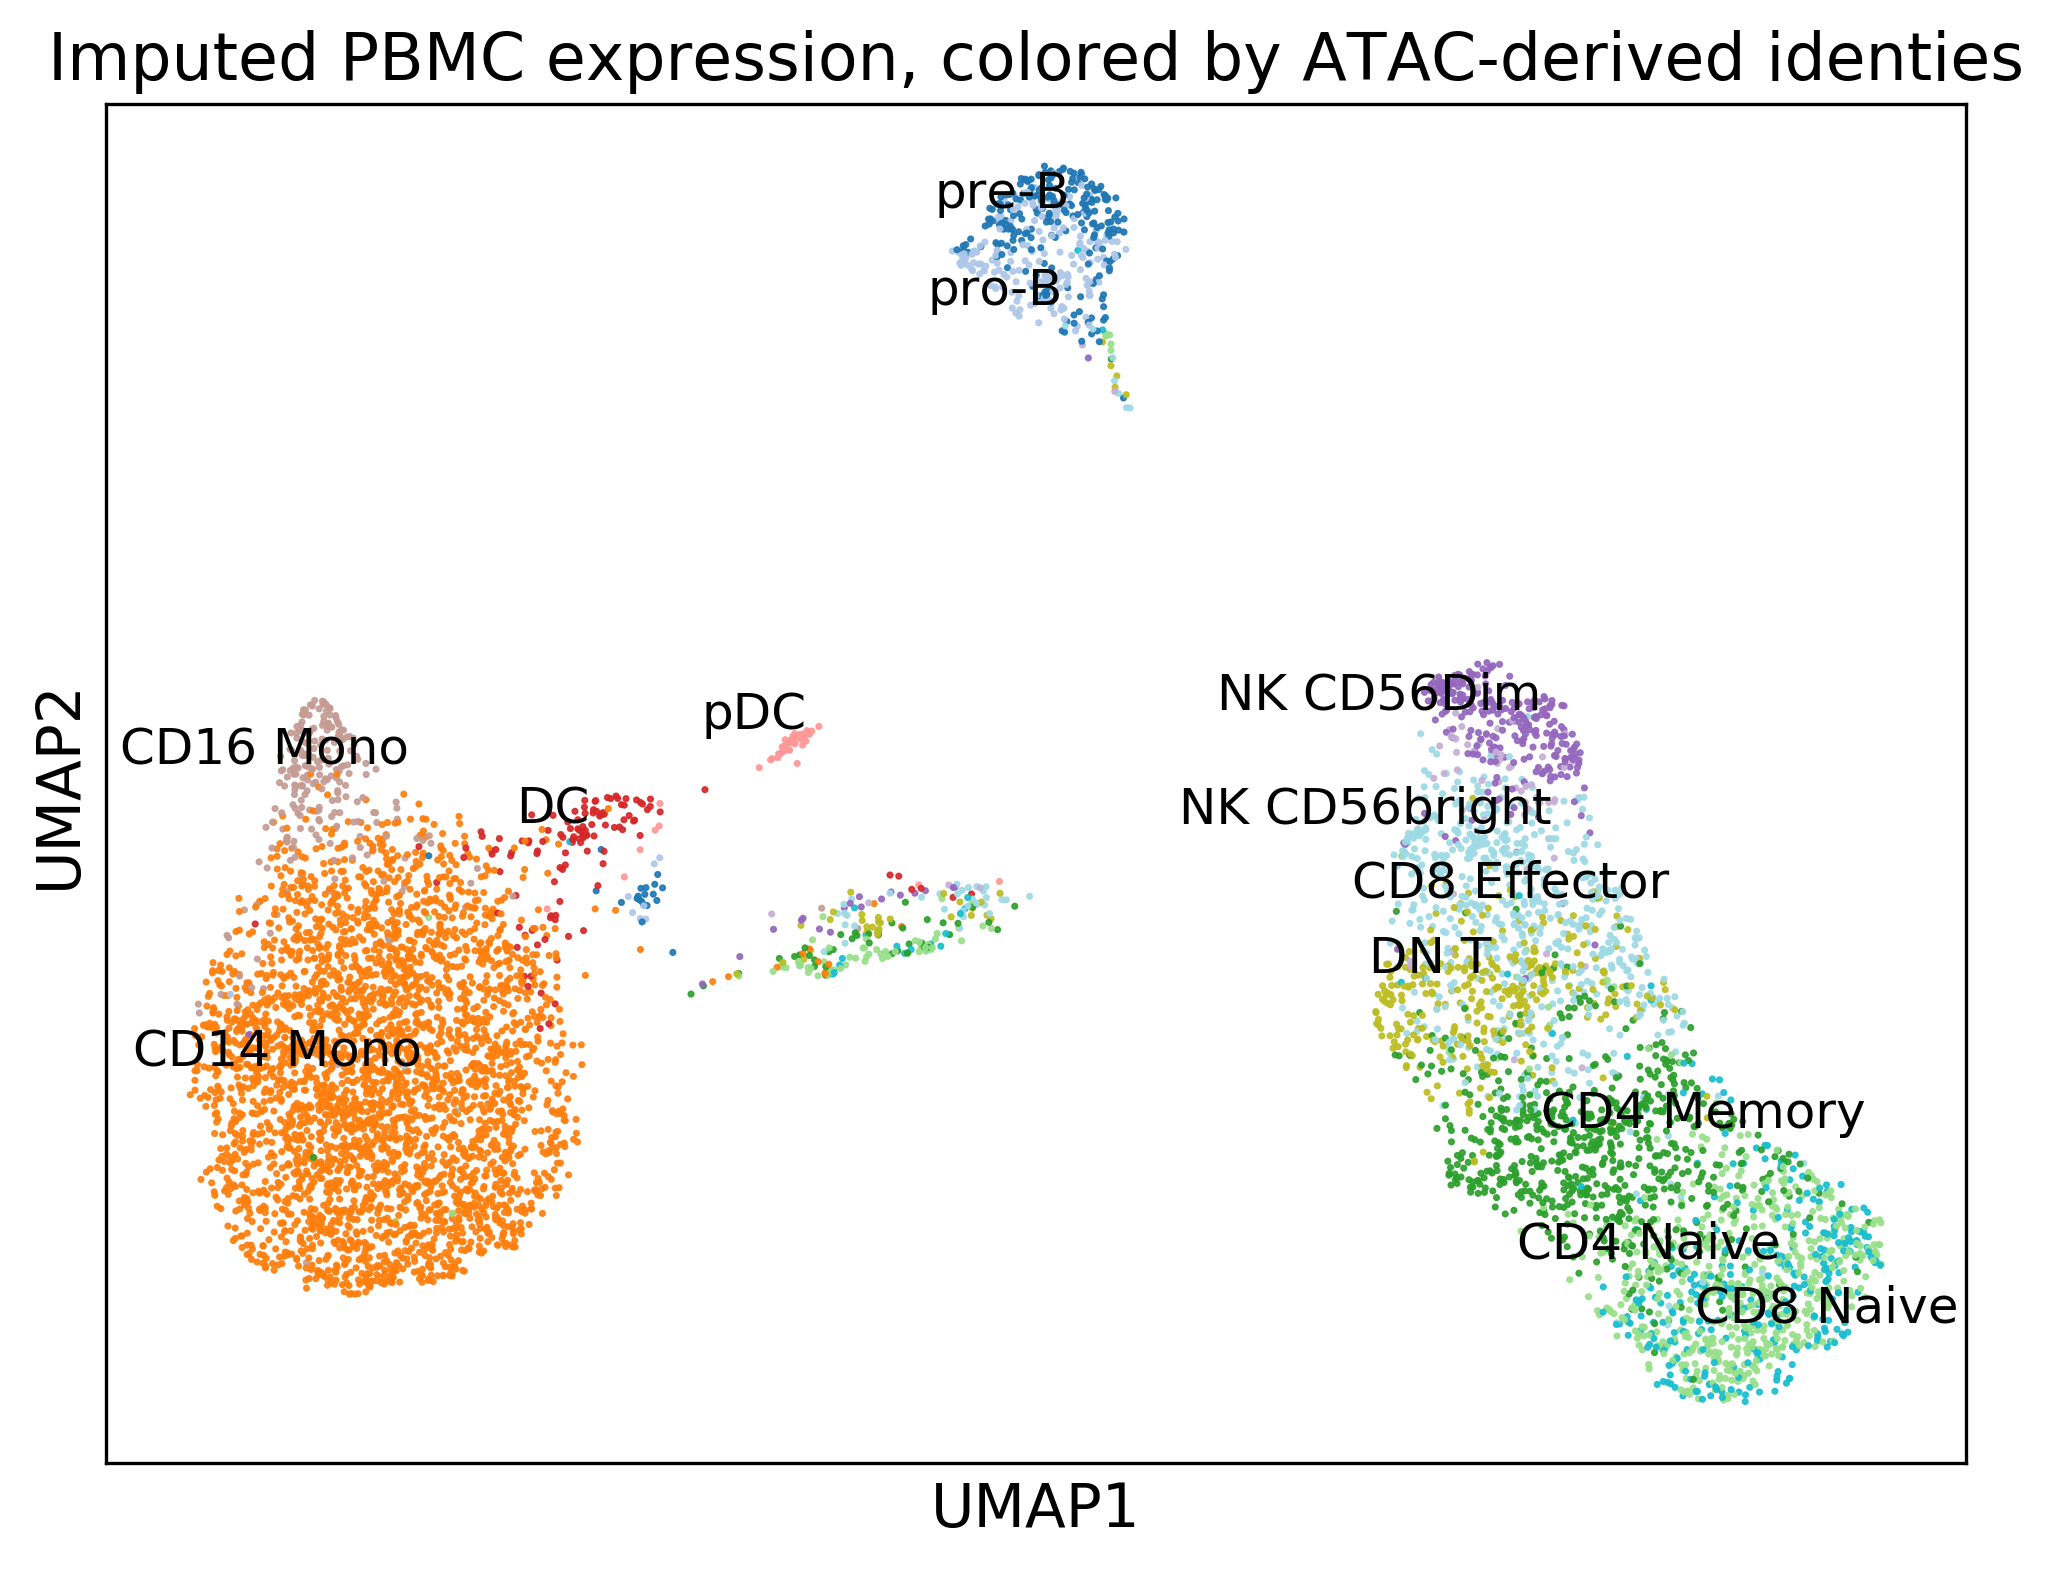

In [10]:
importlib.reload(plot_utils)

def celltype_to_color_atac_base(celltype:str):
    """Assign each celltype a consistent, unique color"""
    tab20 = plt.get_cmap("tab20")
    mapping = {
        "CD14 Mono": tab20(2),
        "CD16 Mono": tab20(11),
        "CD4 Memory": tab20(4),
        "CD4 Naive": tab20(5),
        "CD8 Effector": tab20(19),
        "CD8 Naive": tab20(18),
        "DC": tab20(6),
        "DN T": tab20(16),
        "NK CD56Dim": tab20(8),
        "NK CD56bright": tab20(9),
        "pDC": tab20(7),
        "pre-B": tab20(0),
        "pro-B": tab20(1),
    }
    rgb = dict(enumerate(mapping.values()))[celltype][:3]  # Drops alpha transparency
    if np.any(np.array(rgb) > 1):
        # Mpl does RGB in float [0, 1]
        # https://matplotlib.org/3.1.1/tutorials/colors/colors.html
        rgb = np.array(rgb) / 255
    return tuple(rgb)

plot_utils.plot_clustering_anndata_direct_label(
    pbmc_rna_log,
    color="seurat_clustername",
    cmap=celltype_to_color_atac_base,
    adjust=True,
    title="Imputed PBMC expression, colored by ATAC-derived identies",
).show()

## Highlight the expression of key marker genes

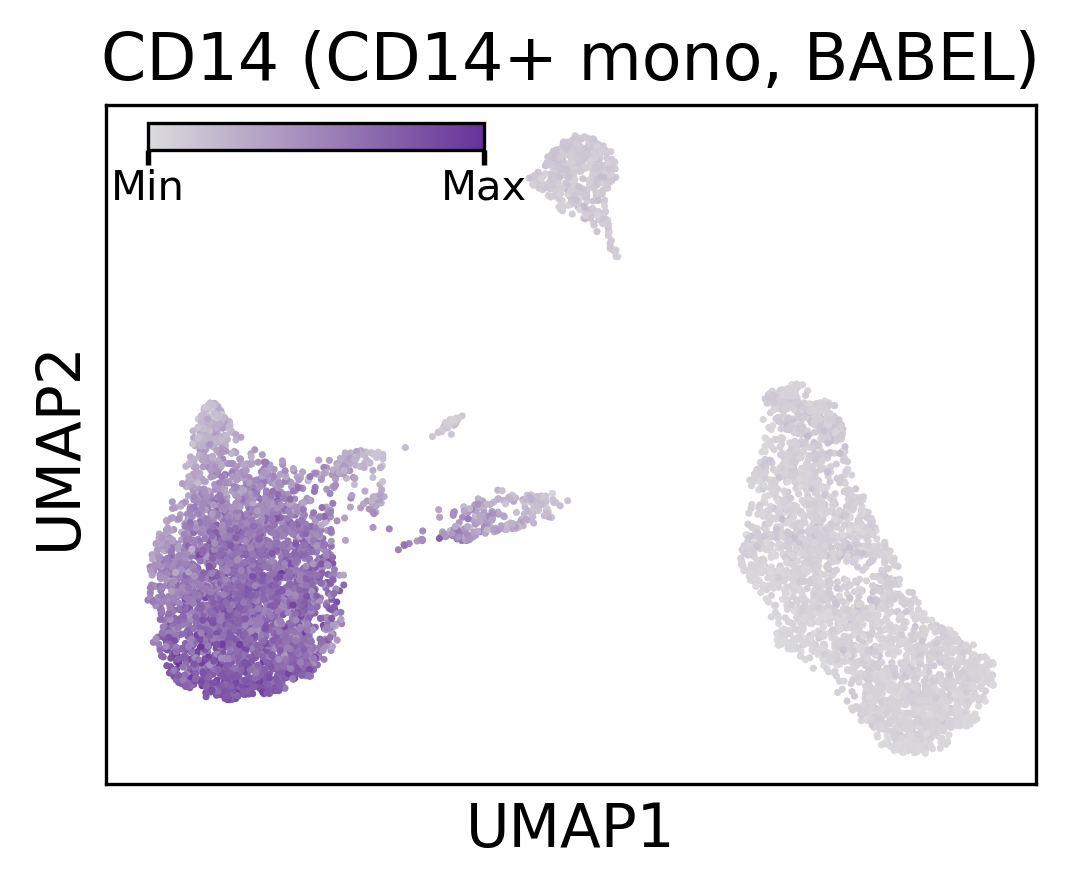

In [11]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "CD14",
    title="CD14 (CD14+ mono, BABEL)",
    cbar_pos=[0.16, 0.83, 0.28, 0.03],
).show()

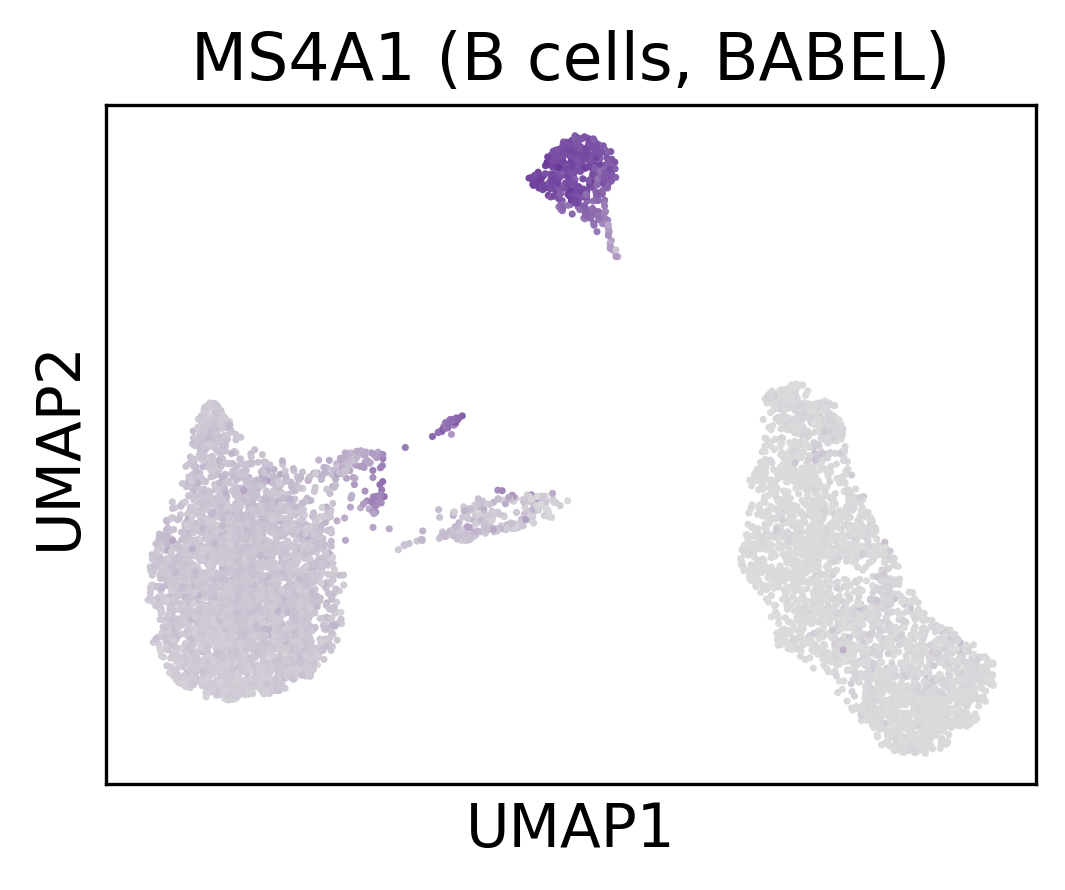

In [12]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "MS4A1",
    title="MS4A1 (B cells, BABEL)",
).show()

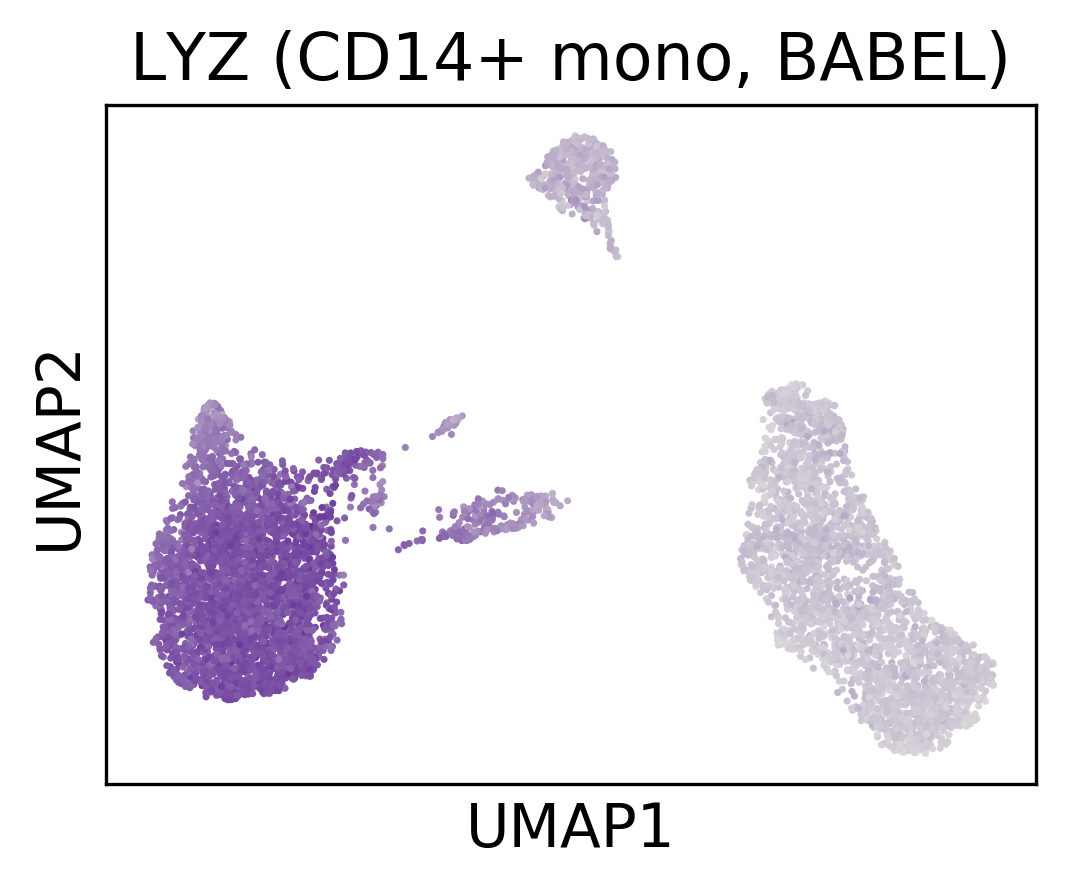

In [14]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "LYZ",
    title="LYZ (CD14+ mono, BABEL)",
).show()

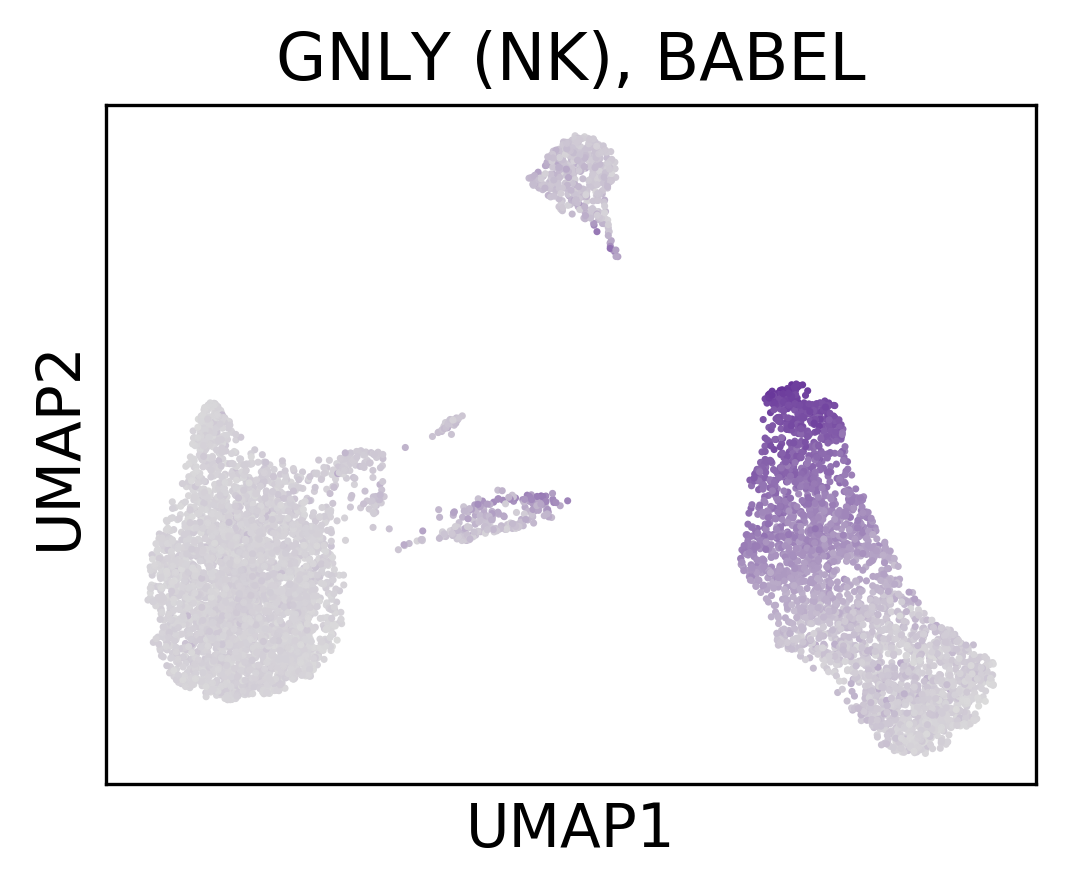

In [15]:
plot_utils.plot_clustering_anndata_gene_color(
    pbmc_rna_log,
    "GNLY",
    title="GNLY (NK), BABEL",
).show()